Python Notebook for evaluation of our finetuned model. More specifically, we want to test models ability to update python docstrings.

For this we randomly sampled 100 examples of code with outdated docstrings. We then generated new docstrings, both with the old model and with the finetuned model. We evaluated these docstrings with GPT-3.5 and GPT-4o by asking them to rate, which docstring is the most appropriate for the code.

In [15]:
#!pip install openai
#!pip install requests
#!pip install typing
#!pip install matplotlib

In [2]:
import json
import random

with open('../Train_Test_Data/test_data.json', 'r') as file:
    data = json.load(file)

filtered_elements = [element for element in data if element.get('l') is False]
sampled_elements = random.sample(filtered_elements, min(100, len(filtered_elements)))

with open('100_last_test_data.json', 'w') as file:
    json.dump(sampled_elements, file, indent=4)

In [3]:
import requests
from model import TestQuery
from typing import Dict, Any

def _do_request(
        query: TestQuery,
        endpoint: str
    ) -> Dict[str, Any]:
        response = requests.post(
            url=f"http://delos.eaalab.hpi.uni-potsdam.de:9011{endpoint}",
            json=query.model_dump()
        )
        response.raise_for_status()
        return response.json()

In [4]:
with open('100_last_test_data.json', 'r') as file:
    data = json.load(file)

codes = [element.get('c') for element in data]
docstrings = [element.get('d') for element in data]

In [5]:
num_generations = 100

In [6]:
split_codes = []
split_codes.append(codes[:25])
split_codes.append(codes[25:50])
split_codes.append(codes[50:75])
split_codes.append(codes[75:])

In [7]:
split_docstrings = []
split_docstrings.append(docstrings[:25])
split_docstrings.append(docstrings[25:50])
split_docstrings.append(docstrings[50:75])
split_docstrings.append(docstrings[75:])

In [8]:
print("Number of batches: " + str(len(split_codes)))
print("Batch size: " + str(len(split_codes[3])))

Number of batches: 4
Batch size: 25


In [9]:
from pydantic_model import TestMethod, NoneTestParameters, GenerationParameters, SampleMethod

gen_mid = "google/codegemma-2b"

all_responses_old_model = {'results' : []}

for i in range(4):
    test_query = TestQuery(
        mid=gen_mid,
        codes=split_codes[i],
        docstrings=split_docstrings[i],
        test_method=TestMethod.UPDATE,
        test_parameters=NoneTestParameters(
            generation_parameters=GenerationParameters(
                max_new_tokens=256,
                sample_method=SampleMethod.TOP_P,
                top_p=0.85,
                temperature=0.5
            )
        )
    )

    response_old_model = _do_request(test_query, "/test")
    all_responses_old_model['results'].extend(response_old_model['results'])

In [10]:
from pydantic_model import TestMethod, NoneTestParameters, GenerationParameters, SampleMethod

gen_mid = "checkpoints/finetuned_0"

all_responses_finetuned_model = {'results' : []}

for i in range(4):
    test_query = TestQuery(
        mid=gen_mid,
        codes=split_codes[i],
        docstrings=split_docstrings[i],
        test_method=TestMethod.UPDATE,
        test_parameters=NoneTestParameters(
            generation_parameters=GenerationParameters(
                max_new_tokens=256,
                sample_method=SampleMethod.TOP_P,
                top_p=0.85,
                temperature=0.5
            )
        )
    )

    response_finetuned_model = _do_request(test_query, "/test")
    all_responses_finetuned_model['results'].extend(response_finetuned_model['results'])

In [11]:
print("Number of code examples: " + str(len(codes)))
print("Number of docstrings: " + str(len(docstrings)))
print("Number of updated docstrings with original model: " + str(len(all_responses_old_model['results'])))
print("Number of updated docstrings with finetuned model: " + str(len(all_responses_finetuned_model['results'])))
print("Target number: " + str(num_generations))

Number of code examples: 100
Number of docstrings: 100
Number of updated docstrings with old model: 100
Number of updated docstrings with finetuned model: 100
Target number: 100


In [12]:
with open('../../open_ai_key_DO_NOT_PUSH.secret', 'r') as file:
    api_key = file.read()

In [16]:
from openai import OpenAI
client = OpenAI(api_key=api_key)

gpt3_completions = []

for i in range(0):
#for i in range(num_generations):
    gpt3_completion = client.chat.completions.create(
          model="gpt-3.5-turbo",
          messages=[{"role": "system", "content": "You are an experienced python software developer."},
                    {"role": "user", "content": "Rate how well the following three docstrings fit to the given python code. Rate each docstring seperately and don't compare them with each other."},
                    {"role": "user", "content": "Code example: " + codes[i]},
                    {"role": "user", "content": "Docstring-0 example: " + docstrings[i]},
                    {"role": "user", "content": "Docstring-1 example: " + all_responses_old_model['results'][i]['updated_docstring']},
                    {"role": "user", "content": "Docstring-2 example: " + all_responses_finetuned_model['results'][i]['updated_docstring']},
                    {"role": "user", "content": "Explain your reasoning for each docstring and then if Docstring-0 is the best, print 'docstring-0_better'. If Docstring-1 is the best, print 'docstring-1_better'. If Docstring-2 is the best, print 'docstring-2_better'. If none of the docstrings fit, print 'none_fit'."}
          ]
    )
    gpt3_completions.append(gpt3_completion)

In [17]:
gpt3_sums = 0
for gpt3_completion in gpt3_completions:
    try:
        gpt3_sums += gpt3_completion.usage.total_tokens
    except AttributeError:
        pass

print("Number of used tokens with GPT3: " + str(gpt3_sums))

Number of used tokens with GPT3: 49047


In [18]:
with open("gpt_3_5_ratings.json", "w") as f:
    json.dump([gpt3_completion.choices[0].message.content for gpt3_completion in gpt3_completions], f, indent=4)

In [1]:
import json
with open("gpt_3_5_ratings.json", "r") as f:
    data = json.load(f)

gpt3_original_docstring = 0
gpt3_old_model_updated_docstring = 0
gpt3_finetuned_model_updated_docstring = 0
gpt3_none_fit = 0

for d in data:
    if 'docstring-0_better' in d:
        gpt3_original_docstring +=1
    elif 'docstring-1_better' in d:
        gpt3_old_model_updated_docstring +=1
    elif 'docstring-2_better' in d:
        gpt3_finetuned_model_updated_docstring +=1
    elif 'none_fit' in d:
        gpt3_none_fit +=1

In [4]:
print("GPT3: ")
print("# Original docstring is best: " + str(gpt3_original_docstring))
print("# Updated docstring from original model is best: " + str(gpt3_old_model_updated_docstring))
print("# Updated docstring from finetuned model is best: " + str(gpt3_finetuned_model_updated_docstring))
print("# None fit: " + str(gpt3_none_fit))
print("---")
print("Total # of ratings: " + str(gpt3_original_docstring + gpt3_old_model_updated_docstring + gpt3_finetuned_model_updated_docstring + gpt3_none_fit))

GPT3: 
# Original docstring is best: 2
# Updated docstring from original model is best: 46
# Updated docstring from finetuned model is best: 21
# None fit: 25
---
Total # of ratings: 94


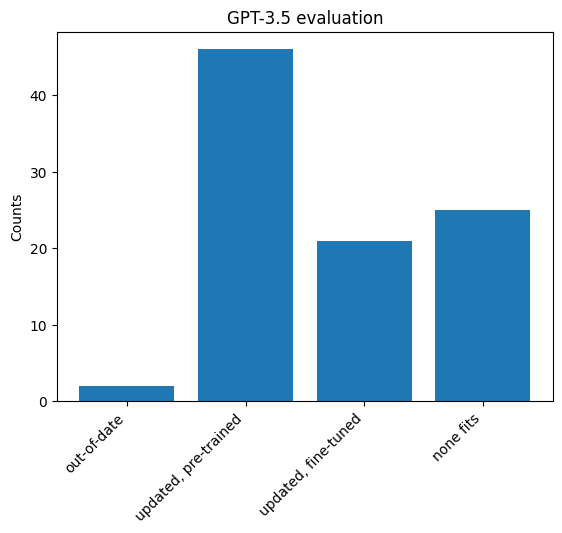

In [4]:
import matplotlib.pyplot as plt

categories = ["out-of-date", "updated, pre-trained", "updated, fine-tuned", "none fits"]
values = [gpt3_original_docstring, gpt3_old_model_updated_docstring, gpt3_finetuned_model_updated_docstring, gpt3_none_fit]

plt.bar(categories, values)

plt.title("GPT-3.5 evaluation")
plt.ylabel("Counts")

plt.xticks(rotation=45, ha='right')

plt.show()

In [23]:
from openai import OpenAI
client = OpenAI(api_key=api_key)

gpt4_completions = []

for i in range(0):
#for i in range(num_generations):
    gpt4_completion = client.chat.completions.create(
          model="gpt-4o",
          messages=[{"role": "system", "content": "You are an experienced python software developer."},
                    {"role": "user", "content": "Rate how well the following three docstrings fit to the given python code. Rate each docstring seperately and don't compare them with each other."},
                    {"role": "user", "content": "Code example: " + codes[i]},
                    {"role": "user", "content": "Docstring-0 example: " + docstrings[i]},
                    {"role": "user", "content": "Docstring-1 example: " + all_responses_old_model['results'][i]['updated_docstring']},
                    {"role": "user", "content": "Docstring-2 example: " + all_responses_finetuned_model['results'][i]['updated_docstring']},
                    {"role": "user", "content": "Briefly explain your reasoning for each docstring and then if Docstring-0 is the best, print 'docstring-0_better'. If Docstring-1 is the best, print 'docstring-1_better'. If Docstring-2 is the best, print 'docstring-2_better'. If none of the docstrings fit, print 'none_fit'."}
          ]
    )
    gpt4_completions.append(gpt4_completion)

In [25]:
gpt4_sums = 0
for gpt4_completion in gpt4_completions:
    try:
        gpt4_sums += gpt4_completion.usage.total_tokens
    except AttributeError:
        pass

print("Number of used tokens with GPT4: " + str(gpt4_sums))

Number of used tokens with GPT4: 58487


In [26]:
with open("gpt_4_ratings.json", "w") as f:
    json.dump([gpt4_completion.choices[0].message.content for gpt4_completion in gpt4_completions], f, indent=4)

In [2]:
with open("gpt_4_ratings.json", "r") as f:
    data = json.load(f)

gpt4_original_docstring = 0
gpt4_old_model_updated_docstring = 0
gpt4_finetuned_model_updated_docstring = 0
gpt4_none_fit = 0

for d in data:
    if 'docstring-0_better' in d:
        gpt4_original_docstring +=1
    elif 'docstring-1_better' in d:
        gpt4_old_model_updated_docstring +=1
    elif 'docstring-2_better' in d:
        gpt4_finetuned_model_updated_docstring +=1
    elif 'none_fit' in d:
        gpt4_none_fit +=1

In [7]:
print("GPT4: ")
print("# Original docstring is best: " + str(gpt4_original_docstring))
print("# Updated docstring from original model is best: " + str(gpt4_old_model_updated_docstring))
print("# Updated docstring from finetuned model is best: " + str(gpt4_finetuned_model_updated_docstring))
print("# None fit: " + str(gpt4_none_fit))
print("---")
print("Total # of ratings: " + str(gpt4_original_docstring + gpt4_old_model_updated_docstring + gpt4_finetuned_model_updated_docstring + gpt4_none_fit))

GPT4: 
# Original docstring is best: 0
# Updated docstring from original model is best: 42
# Updated docstring from finetuned model is best: 19
# None fit: 38
---
Total # of ratings: 99


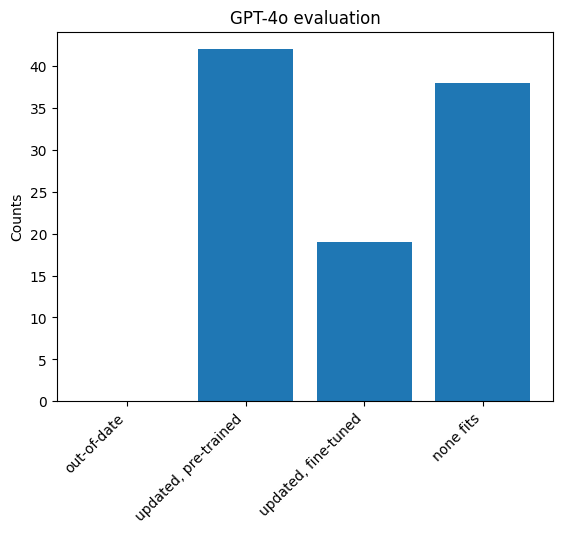

In [6]:
categories = ["out-of-date", "updated, pre-trained", "updated, fine-tuned", "none fits"]
values = [gpt4_original_docstring, gpt4_old_model_updated_docstring, gpt4_finetuned_model_updated_docstring, gpt4_none_fit]

plt.bar(categories, values)

plt.title("GPT-4o evaluation")
plt.ylabel("Counts")

plt.xticks(rotation=45, ha='right')

plt.show()

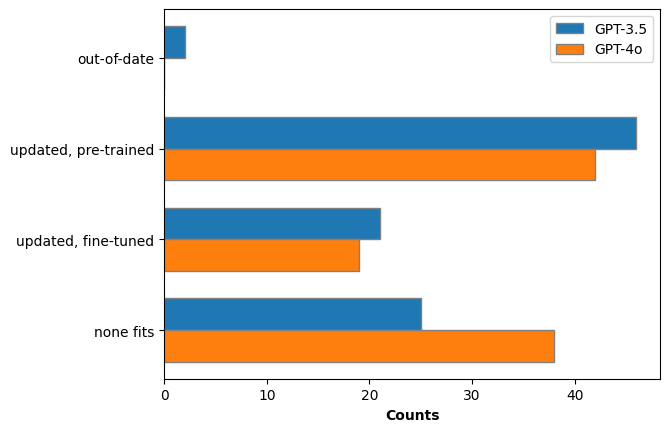

In [30]:
import numpy as np

categories = ["out-of-date", "updated, pre-trained", "updated, fine-tuned", "none fits"]
values1 = [gpt3_original_docstring, gpt3_old_model_updated_docstring, gpt3_finetuned_model_updated_docstring, gpt3_none_fit]
values2 = [gpt4_original_docstring, gpt4_old_model_updated_docstring, gpt4_finetuned_model_updated_docstring, gpt4_none_fit]

bar_height = 0.35

r1 = np.arange(len(values1))
r2 = [x + bar_width for x in r1]

plt.barh(r1, values1, color='tab:blue', height=bar_height, edgecolor='grey', label='GPT-3.5')
plt.barh(r2, values2, color='tab:orange', height=bar_height, edgecolor='grey', label='GPT-4o')

plt.xlabel('Counts', fontweight='bold')
plt.yticks([r + bar_height / 2 for r in range(len(values1))], categories)
plt.gca().invert_yaxis()

plt.legend()

plt.show()

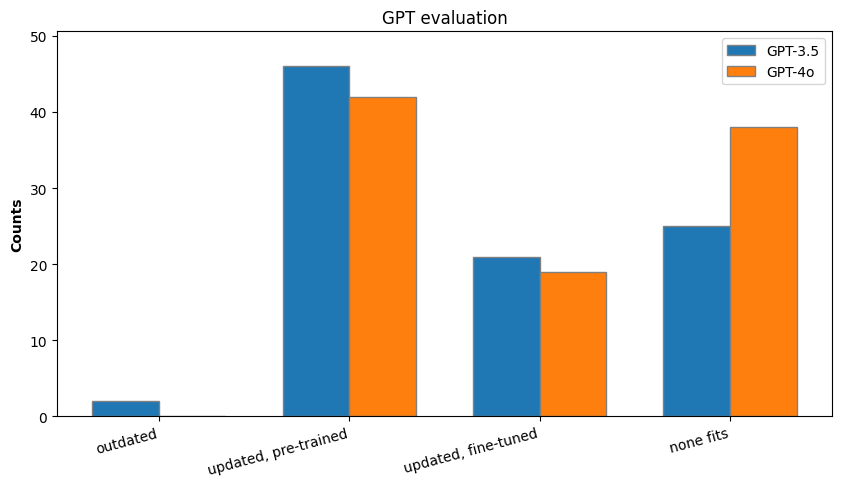

In [4]:
import numpy as np
import matplotlib.pyplot as plt

categories = ["outdated", "updated, pre-trained", "updated, fine-tuned", "none fits"]
values1 = [gpt3_original_docstring, gpt3_old_model_updated_docstring, gpt3_finetuned_model_updated_docstring, gpt3_none_fit]
values2 = [gpt4_original_docstring, gpt4_old_model_updated_docstring, gpt4_finetuned_model_updated_docstring, gpt4_none_fit]

bar_width = 0.35

r1 = np.arange(len(values1))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 5))  # Adjust the width and height here

plt.bar(r1, values1, color='tab:blue', width=bar_width, edgecolor='grey', label='GPT-3.5')
plt.bar(r2, values2, color='tab:orange', width=bar_width, edgecolor='grey', label='GPT-4o')

plt.ylabel('Counts', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(len(values1))], categories, rotation=15, ha='right')
plt.title("GPT evaluation")

plt.ylim(0, max(max(values1), max(values2)) * 1.1)

plt.legend()

plt.show()
